In [1]:
exp_no = 1
batch_size = _batch_size = 32
nb_classes = _nb_classes = 5
nb_samples_per_class = _nb_samples_per_class = 10
_input_height = _input_width = 40
colorspace = 'RGB'
channels = {'RGB':3, 'L':1}
_iterations = 100000

img_size = (_input_height, _input_width)
img_shape = [_input_height, _input_width, channels[colorspace]]

input_size = _input_height * _input_width * channels[colorspace]
cell = 'DNC'
nb_reads = _nb_reads = 1
controller_size = _controller_size = 100
memory_size = _memory_locations = 128
memory_dim = ar_memory_word_size = 20
summary_interval = 1
checkpt_write_interval = 1000
dataset = 'vgg_flower'
splits=[70,15,15]

learning_rate = _learning_rate = 1e-3
start=0
save_dir='./Experiments_New/Convolutional4layer'
_start_iterations = 0

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from packaging import version
import os
import sys


In [3]:
tf.compat.v1.logging.set_verbosity('DEBUG')

In [4]:
sys.path.append('./metalearning')
os.environ["RECORDS"]="./datasets/Records"

In [ ]:
from metalearning_tasks.fixed_shot_classification_v2 import DatasetGenerator
from models.model_builder import create_one_hot_model_convolutional, create_cnn

In [6]:
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_error = tf.keras.metrics.Mean('train_error', dtype=tf.float32)

In [7]:
def metric_accuracy(_nb_classes,_nb_samples_per_class,labels, outputs):
    seq_length = _nb_classes * _nb_samples_per_class
    outputs = np.argmax(outputs, axis=-1)
    correct = [0] * seq_length
    total = [0] * seq_length
    for i in range(np.shape(labels)[0]):
        label = labels[i]
        output = outputs[i]
        class_count = {}
        for j in range(seq_length):
            class_count[label[j]] = class_count.get(label[j], 0) + 1
            total[class_count[label[j]]] += 1
            if label[j] == output[j]:
                correct[class_count[label[j]]] += 1
    return [float(correct[i]) / total[i] if total[i] > 0. else 0.
            for i in range(1, _nb_samples_per_class + 1)]
last_logged_ep=0

@tf.function
def trainstep(model, data_generator, optimizer):
    image, label = data_generator.generate_batch("train",
                                                 _batch_size)
    images = tf.reshape(image, (_batch_size,-1,40,40,3))
    one_hot_target = tf.one_hot(label, _nb_classes, axis=-1)
    offset_target_var = tf.concat([tf.zeros_like(tf.expand_dims(
        one_hot_target[:, 0], 1)), one_hot_target[:, :-1]], axis=1)

    with tf.GradientTape() as tape:
        output = model([images, offset_target_var])
        loss = tf.reduce_mean(
                    tf.reduce_sum(
                        tf.nn.softmax_cross_entropy_with_logits(
                            labels=one_hot_target,
                            logits=output
                        ),
                        axis=1)
                  )
        grads, _ = tf.clip_by_global_norm(
            tape.gradient(loss, model.trainable_variables),
            50)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

def train(model, data_genarator, _start_iterations, _iterations, _learning_rate, cell, _batch_size, _nb_classes, save_dir):
    optimizer = tf.keras.optimizers.Adam(lr=_learning_rate)
    print("1st\t2nd\t3rd\t4th\t5th\t6th\t7th\t8th\t9th\t10th\tbatch\tloss\tdt")
    logdir = f"{save_dir}/{dataset}/{cell}/{_learning_rate}/{exp_no}/logs"
    summary_writer = tf.summary.create_file_writer(logdir)
    dt = datetime.now()
    accuracies = []
    losses = []
    for ep in range(_start_iterations, _iterations):
        if ep % summary_interval == 0:
            image, label = data_generator.generate_batch("train",
                                                         _batch_size)
            images = tf.reshape(image, (_batch_size,-1,40,40,3))
            one_hot_target = tf.one_hot(label, _nb_classes, axis=-1)
            offset_target_var = tf.concat([tf.zeros_like(tf.expand_dims(
                one_hot_target[:, 0], 1)), one_hot_target[:, :-1]], axis=1)
            output = model([images, offset_target_var])
            loss = tf.reduce_mean(
                        tf.reduce_sum(
                            tf.nn.softmax_cross_entropy_with_logits(
                                labels=one_hot_target,
                                logits=output),
                            axis=1))
            accuracy = metric_accuracy(_nb_classes, _nb_samples_per_class, label, output)
            accuracies.append((ep,accuracy))
            dt = datetime.now() - dt

            for accu in accuracy:
                print('%.4f' % accu, end='\t')
            print('%d\t%.4f\t%.4f' % (ep, loss, dt.total_seconds()))
            train_loss(loss)
            losses.append((ep,train_loss.result()))

            dt = datetime.now()
        if ep % checkpt_write_interval == 1 and ep > 0:
            model.save_weights(f"{save_dir}/{dataset}/{cell}/{_learning_rate}/{exp_no}" + "/model.")
            with open(f"{save_dir}/{dataset}/{cell}/{_learning_rate}/{exp_no}" + "/model.iteration", 'w') as f:
                _start_iterations =  f.write(str(ep))
            with summary_writer.as_default():
              for ep_idx, accuracy in accuracies:
                for i, accu in enumerate(accuracy):
                    tf.summary.scalar(f'train_acc_{i}',
                                      accu,
                                      step=ep_idx)
              for ep_idx, loss_res in losses:
                tf.summary.scalar('train_loss',
                                  train_loss.result(),
                                  step=ep_idx)
            last_logged_ep=ep
            accuracies=[]
            losses=[]
        loss = trainstep(model, data_generator, optimizer)
        train_loss(loss)


In [8]:
model = create_one_hot_model_convolutional(img_shape,
                                           [5],
                                           5,
                                           _batch_size,
                                           cell,
                                          '4layerConv')
ds_root = f'./datasets/Records/{dataset}'
data_generator = DatasetGenerator(data_folder=ds_root,
                                  splits=splits,
                                  nb_samples_per_class=nb_samples_per_class,
                                  img_size=img_size,
                                  colorspace=colorspace,
                                  pre_scale=(60,60),
                                  augment=False
                                )

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(32, None, 40, 40,  0                                            
__________________________________________________________________________________________________
tf.stop_gradient_1 (TFOpLambda) (32, None, 40, 40, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
time_distributed (TimeDistribut (32, None, 102400)   113600      tf.stop_gradient_1[0][0]         
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (32, None, 102400)   0           time_distributed[0][0]           
____________________________________________________________________________________________

In [10]:
b1 = data_generator.generate_batch('train', _batch_size)

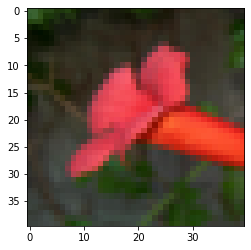

In [11]:
plt.imshow(tf.reshape(b1[0][0,0,:],(40,40,3)))

In [ ]:
train(model, data_generator, _start_iterations, _iterations, _learning_rate, cell, _batch_size, _nb_classes, save_dir)

1st	2nd	3rd	4th	5th	6th	7th	8th	9th	10th	batch	loss	dt
0.1938	0.1375	0.1938	0.2125	0.2115	0.1933	0.1739	0.1641	0.1909	0.2308	0	80.5048	4.0454
0.2000	0.2000	0.2000	0.2000	0.2025	0.2000	0.1931	0.1860	0.2170	0.2308	1	81.1629	18.3632
0.1750	0.1750	0.1938	0.1761	0.1871	0.1688	0.2192	0.1846	0.1491	0.2222	2	80.9375	14.0853
0.2000	0.2000	0.2000	0.2025	0.1987	0.1948	0.2098	0.2214	0.2281	0.2353	3	80.9618	13.7003
0.2000	0.2000	0.2000	0.2000	0.1899	0.1854	0.1818	0.1938	0.1842	0.1848	4	80.8847	13.7948
0.2000	0.2000	0.2013	0.2025	0.2038	0.2026	0.2109	0.2121	0.2119	0.2553	5	80.7735	13.7891
0.2000	0.1938	0.1950	0.1950	0.1923	0.1959	0.2000	0.2000	0.2182	0.2222	6	80.6805	13.7999
0.2000	0.2000	0.2000	0.2013	0.1987	0.1948	0.2041	0.2248	0.2130	0.2209	7	80.6868	13.8410
0.1812	0.2000	0.2000	0.2000	0.1911	0.1948	0.2000	0.1923	0.2124	0.1910	8	80.7969	13.7627
0.1688	0.2000	0.2000	0.2000	0.1962	0.1948	0.1871	0.1890	0.2054	0.1758	9	80.8701	13.7748
0.2062	0.2000	0.2000	0.2025	0.1923	0.1854	0.1986	0.1818	0.1981	0.2

0.2000	0.2000	0.1938	0.1824	0.1962	0.2078	0.2109	0.1955	0.2035	0.1818	92	80.5088	13.8346
0.1688	0.2075	0.2390	0.2278	0.2051	0.1733	0.1761	0.1938	0.1698	0.1744	93	80.6482	13.8069
0.1750	0.1938	0.2264	0.1950	0.1456	0.1765	0.2014	0.2045	0.1983	0.2111	94	80.6031	13.8604
0.2062	0.1938	0.2000	0.2250	0.2188	0.2267	0.1971	0.1803	0.1635	0.1882	95	80.5981	13.7894
0.2062	0.2500	0.2062	0.2264	0.2138	0.2013	0.1892	0.1799	0.1966	0.2045	96	80.5727	13.7120
0.1938	0.1938	0.1938	0.2278	0.1975	0.1908	0.1901	0.1832	0.1786	0.2021	97	80.6076	13.8088
0.2188	0.1688	0.1812	0.1887	0.1847	0.2157	0.2083	0.2137	0.2321	0.2471	98	80.6636	13.9029
0.1938	0.2062	0.2437	0.2342	0.2102	0.1859	0.1862	0.1880	0.1842	0.1839	99	80.5880	13.7357
0.2125	0.2188	0.2500	0.2075	0.1772	0.1921	0.1857	0.1984	0.1759	0.1818	100	80.6235	13.7581
0.2125	0.2500	0.2313	0.1938	0.1938	0.1824	0.1918	0.1875	0.1909	0.2135	101	80.6465	13.8820
0.2125	0.2250	0.2437	0.2437	0.2215	0.1908	0.2174	0.2061	0.2385	0.2222	102	80.5758	13.7891
0.1938	0.1625	0.15

In [ ]:
tf.autograph.set_verbosity(0)